# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [353]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [354]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [355]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [356]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(57, 6)


,title,price,year,link,brand,age
0,toyota camry 2008,3000,2008.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,17.0
1,toyota tundra 2013,16000,2013.0,https://charlottesville.craigslist.org/cto/d/s...,toyota,12.0
2,chev van,4000,NaN,https://charlottesville.craigslist.org/cto/d/p...,missing,NaN
3,1994 dodge ram b1500 van,10750,1994.0,https://charlottesville.craigslist.org/cto/d/l...,dodge,31.0
4,2008 ford f350 super duty,9500,2008.0,https://charlottesville.craigslist.org/cto/d/n...,ford,17.0


With the data in and wrangled, we can now do some analysis:

count       57.000000
mean     10445.596491
std      11121.971735
min       2250.000000
25%       3500.000000
50%       6800.000000
75%      11400.000000
max      62800.000000
Name: price, dtype: float64


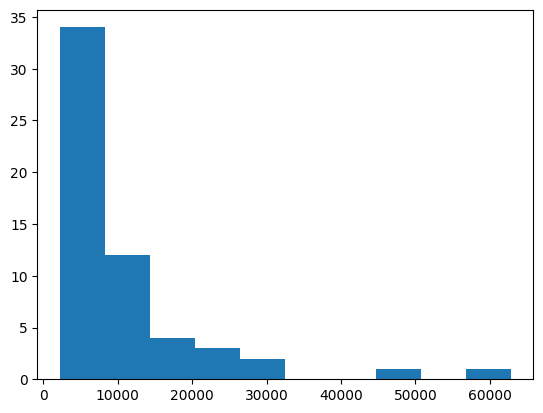

count    52.000000
mean     21.980769
std      15.292559
min       4.000000
25%      12.750000
50%      17.500000
75%      22.000000
max      68.000000
Name: age, dtype: float64


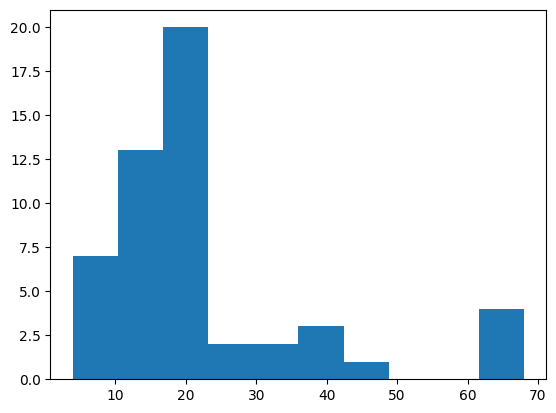

In [357]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [358]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
chevrolet    2.0  18500.000000   5656.854249  14500.0  16500.0  18500.0   
chevy        2.0   2950.000000     70.710678   2900.0   2925.0   2950.0   
dodge        2.0   7375.000000   4772.970773   4000.0   5687.5   7375.0   
ford         8.0  15687.500000  14713.787266   4000.0   6625.0  11500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda        7.0  11157.142857   8854.162325   3000.0   5600.0   7900.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
missing     14.0   9385.642857  16316.805672   2250.0   3300.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   7880.000000   5392.309338   3000.0   4500.0   5200.0   
volkswagen   2.0   4550.000000   2757.716447   2600.0   3575.0   4550.0   

                               
                 75%      max  
brand                          
acura        6375.00   7500.0  
audi        11000.00  11000.0  
bmw          9375.00  10000.0  
chevrolet   20500.00  22500.0  
chevy        2975.00   3000.0  
dodge        9062.50  10750.0  
ford        18125.00  49500.0  
gmc         21250.00  26000.0  
honda       13500.00  29000.0  
jeep         8725.00   8750.0  
kia          2500.00   2500.0  
lexus       11287.50  11400.0  
missing      4949.25  62800.0  
mitsubishi   6800.00   6800.0  
tesla       26900.00  26900.0  
toyota      10700.00  16000.0  
volkswagen   5525.00   6500.0

In [359]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
chevrolet    2.0  52.000000  22.627417  36.0  44.00  52.0  60.00  68.0
chevy        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         8.0  18.500000   7.982123   8.0  12.50  19.5  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda        7.0  12.000000   4.966555   4.0   9.50  12.0  15.00  19.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     11.0  31.363636  22.870386   7.0  15.50  21.0  49.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  18.400000   4.878524  12.0  17.00  17.0  21.00  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.50  44.0

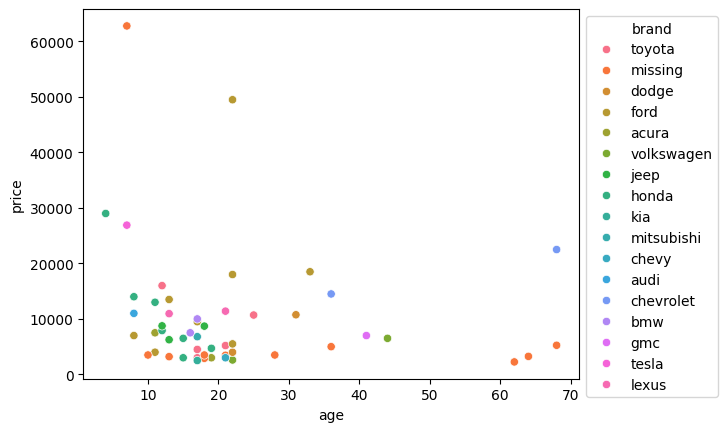

In [360]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.631138 -0.132934
log_age    -0.132934  0.362308
           log_price   log_age
log_price   1.000000 -0.283616
log_age    -0.283616  1.000000


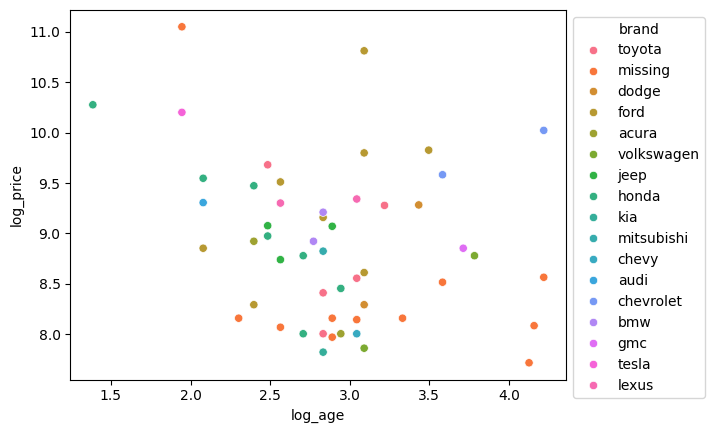

In [361]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

I would like to find consoles for sale on the craigslist videogames page in Charlottesville. I would like to gather the price and title of the console as well to compare prices between consoles and the frequency that each one is being sold. I would like to see if there is a relationship between the price of the console and the title of the console.

In [362]:
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
import re

# Set up headers and Craigslist URL
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/vga#search=1~gallery~0~0'

# Request Craigslist page
raw = requests.get(url, headers=header)
bsObj = soup(raw.content, 'html.parser')

# Find all listings
listings = bsObj.find_all(class_="cl-static-search-result")

# List of gaming consoles
console_list = ["PS5", "PS4", "Wii", "VR", "Meta Quest", "Oculus", "Xbox", "Nintendo Switch",
                "Playstation", "Xbox One", "Xbox 360", "PS3", "PS2", "PS1", "Wii U", "Gamecube",
                "Nintendo 64", "Super Nintendo", "NES", "Sega Genesis", "Atari", "Gameboy", 
                "DS", "3DS", "PSP", "PS Vita"]

data = []

for listing in listings:
    # Extract Title
    title_element = listing.find('div', class_='title')
    title = title_element.get_text().strip().upper() if title_element else "UNKNOWN"

    # Extract Price
    price_element = listing.find('div', class_='price')
    price_text = price_element.get_text().strip() if price_element else "0"

    # Clean price
    price = re.sub(r"[^\d]", "", price_text)
    price = int(price) if price else 0

    # Extract Link
    link_element = listing.find('a', href=True)
    link = link_element['href'] if link_element else "No link found"

    # Match console name based on partial string match
    hits = [console for console in console_list if console.lower() in title.lower()]
    detected_console = hits[0] if hits else 'other'  # Assign "other" if not found

    # Only keep gaming-related listings
    if detected_console != "other":
        data.append({'title': title, 'price': price, 'link': link, 'console': detected_console})

# Convert to DataFrame
df = pd.DataFrame(data)

# Clean columns
df = df[df["price"] > 75] # Price filter to only show listings above $75
df["console"] = df["console"].replace({"Meta Quest": "VR"}) # Replace Meta Quest with VR

# Save filtered data
df.to_csv('./src/craigslist_cville_vgs_filtered.csv', index=False)

# Show updated dataset
print(df)

                                                title  price  \
0   WII CONSOLE, 4 CONTROLLERS/NUNCHUCKS, BALANCE ...     85   
2                              WORKING PS4 WITH GAMES    175   
3   META QUEST 2 WITH BATTERY HEADSET AND CHARGING...    200   
4                                        PS5 SLIM 1TB    600   
8                 HTC VIVE VR HEADSET & TRIPOD TOWERS    150   
16  XBOX ONE X 1 TB, 2 CONTROLLERS, EXT HDD 1TB, 7...    250   
18                      PS4 W/5 GAMES & PS3 W/8 GAMES    200   
19                                PS4 +GAMES FOR SALE    150   
20  XBOX ONE WITH CONTROLLER IN BOX. LIKE NEW DISC...    159   
21  XBOX ONE WITH CONTROLLER IN BOX. LIKE NEW DISC...    159   
24                                           USED PS5    400   

                                                 link console  
0   https://charlottesville.craigslist.org/vgm/d/c...     Wii  
2   https://charlottesville.craigslist.org/vgm/d/t...     PS4  
3   https://charlottesville.craigslist.

/var/folders/tr/mx4sn42j27q4nqp24v7693r00000gn/T/ipykernel_80447/2390740986.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="console", order=df["console"].value_counts().index, palette="viridis")


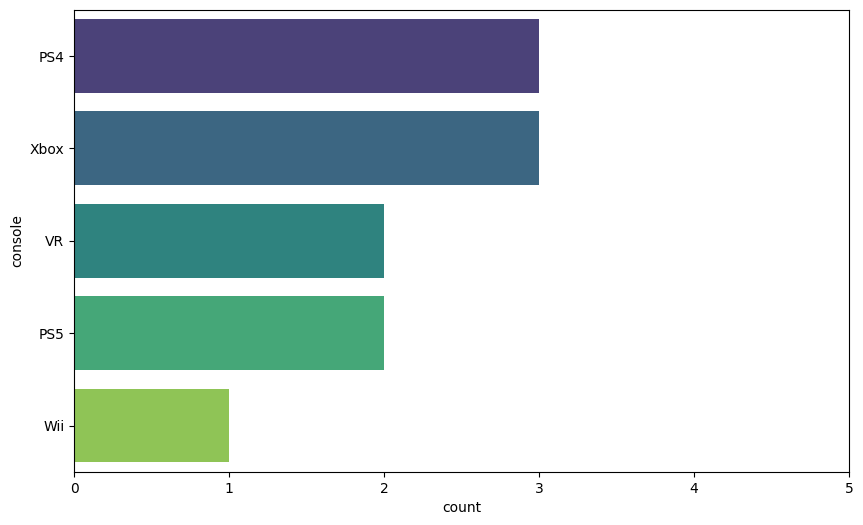

In [363]:
# Plot of frequency of listings per console
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="console", order=df["console"].value_counts().index, palette="viridis")
# change x axis ticks to show every 1 value
plt.gca().set_xticks(range(0, 6, 1))


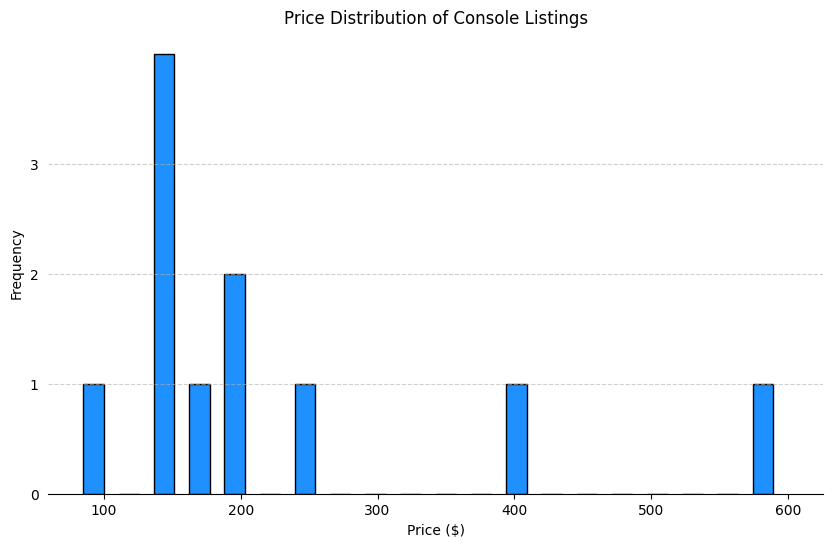

In [364]:
plt.figure(figsize=(10, 6))

plt.hist(df["price"], bins=20, color="dodgerblue", edgecolor="black", width = 15)

plt.xlabel("Price ($)")
plt.ylabel("Frequency")
plt.title("Price Distribution of Console Listings")

# Change yticks to only show every 1 value
plt.gca().set_yticks(range(0, 4, 1))

# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.grid(axis="y", linestyle="--", alpha=0.6)

# get rid of y ticks
plt.gca().tick_params(axis="y", left=False)
plt.show()


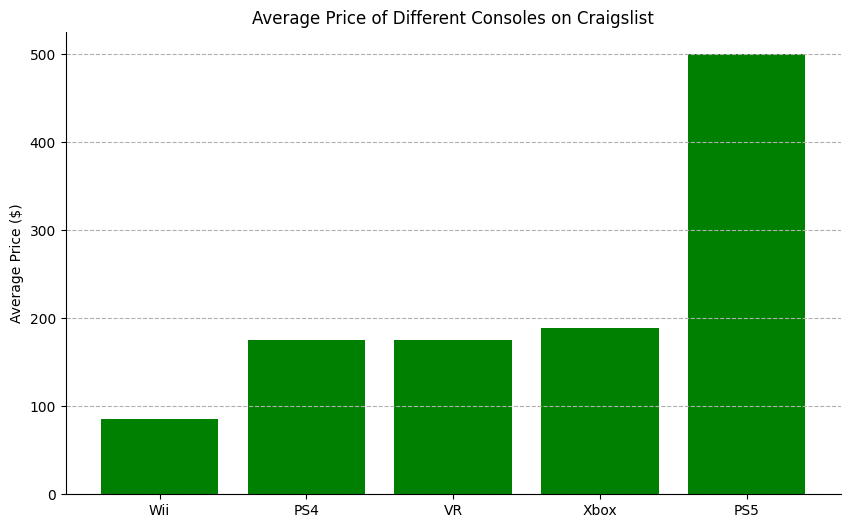

In [366]:

console_avg_price = df.groupby("console")["price"].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.bar(console_avg_price.index, console_avg_price.values, color= "green")

plt.ylabel("Average Price ($)")
plt.title("Average Price of Different Consoles on Craigslist")
plt.grid(axis="y", linestyle="--")
# Remove spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()